# Setup

In [1]:
# pip install ipywidgets mlcroissant nltk

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Data Initialization

In [3]:
data_path = 'FilmSent/new_rotten_tomatoes_dataset.json'
try:
    df = pd.read_json(data_path)
    print(f"Data loaded!")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded!


# Data Cleaning

In [4]:
# Get a shot of the first 3 entries
print(df.head(3))
print(df.columns)

# Describe the dataset
print("This is the description of the full dataset\n", df.describe())

                      title  year                                 emsId  \
0           Prisoner of War  2025  58c6801a-d7d0-49d4-a200-07e9f8e6004f   
1         War of the Worlds  2025  2828f421-1ed7-430d-94c3-e19235ba0d43   
2  Female War: A Nasty Deal  2015  05b14108-fbb6-3e04-86f7-cdc2d40bef0b   

                    vanity   type  critics_score  audience_score  \
0          prisoner_of_war  movie           67.0             NaN   
1   war_of_the_worlds_2025  movie            4.0            20.0   
2  female_war_a_nasty_deal  movie            NaN            83.0   

                                           genres directors  \
0               [Action, Mystery & Thriller, War]        []   
1  [Sci-Fi, Adventure, Drama, Mystery & Thriller]        []   
2                                         [Drama]        []   

                                                cast  \
0  [{'role': 'Actor', 'emsId': 'c8ab0109-b9e3-318...   
1  [{'role': 'Actor', 'emsId': 'c745b7d3-1c29-394...   
2  [{

In [5]:
# Remove the entries with missing scores
df_cleaned = df.dropna(subset=['critics_score', 'audience_score'])
# Describe the cleaned dataset
print("This is the description of the reduced dataset\n", df_cleaned.describe())

This is the description of the reduced dataset
               year  critics_score  audience_score
count  2596.000000    2596.000000     2596.000000
mean   2006.675270      66.803929       67.567797
std      19.098661      27.048541       20.542742
min    1919.000000       0.000000        7.000000
25%    2000.000000      47.000000       53.000000
50%    2013.000000      74.000000       72.000000
75%    2021.000000      90.000000       85.000000
max    2025.000000     100.000000      100.000000


# Exploratory Analysis

<Axes: >

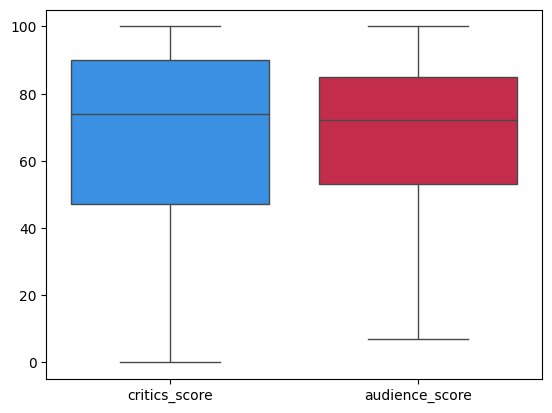

In [6]:
sns.boxplot(data=df_cleaned[['critics_score', 'audience_score']], palette=['dodgerblue', 'crimson'])

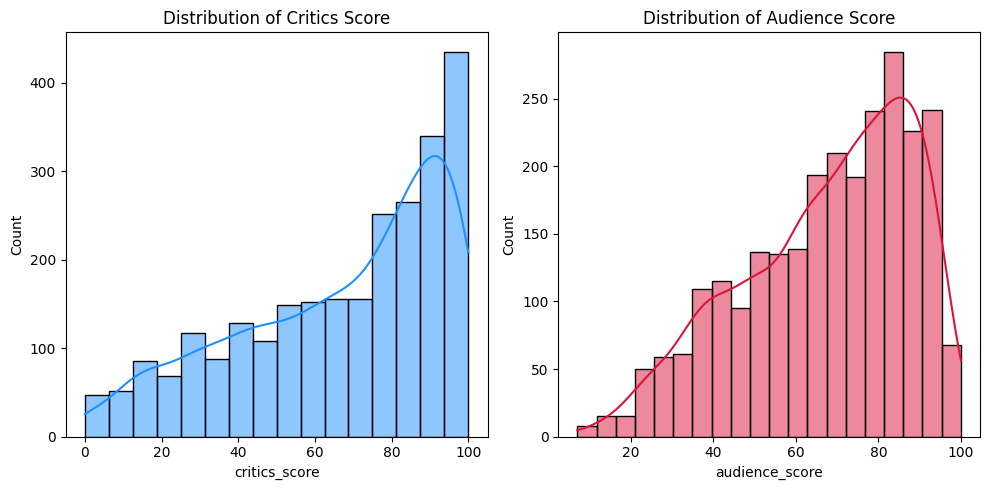

In [7]:
# Plot the scores
plt.figure(figsize=(10, 5))

# Histogram for critics_score
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['critics_score'], kde=True, color='dodgerblue')
plt.title('Distribution of Critics Score')

# Histogram for audience_score
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['audience_score'], kde=True, color='crimson')
plt.title('Distribution of Audience Score')

plt.tight_layout()
plt.savefig('histograms.png')  # Save the figure
plt.show()

Notice that both distributions are skewed to the right i.e. a higher count of high-scored films.

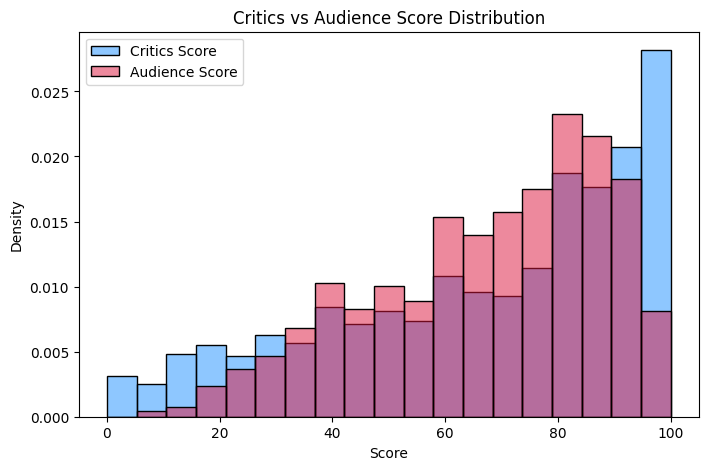

In [8]:
# Superimpose the plots for easier analysis

plt.figure(figsize=(8, 5))

# Create common bins
bins = np.linspace(
    min(df_cleaned['critics_score'].min(), df_cleaned['audience_score'].min()),
    max(df_cleaned['critics_score'].max(), df_cleaned['audience_score'].max()),
    20
)

sns.histplot(
    df_cleaned['critics_score'],
    bins=bins,
    stat='density',
    alpha=0.5,
    label='Critics Score',
    color='dodgerblue'
)

sns.histplot(
    df_cleaned['audience_score'],
    bins=bins,
    stat='density',
    alpha=0.5,
    label='Audience Score',
    color='crimson'
)

plt.title('Critics vs Audience Score Distribution')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()


Let's take a look at the extremes–scores of 0 and 100. We see that there is a larger number of critics that scored movies at the extremes than the audience. However, we see that the audience tended to score the movies at values in the approximate range of 55-90.

From this we can infer that critics may be more comfortable expressing strong dislike and like towards films, whereas the audience may be more apprehensive of giving extreme scores.

In [9]:
df_cleaned[['critics_score', 'audience_score']].corr()

,critics_score,audience_score
critics_score,1.000000,0.639241
audience_score,0.639241,1.000000


<Axes: xlabel='count', ylabel='avg_score'>

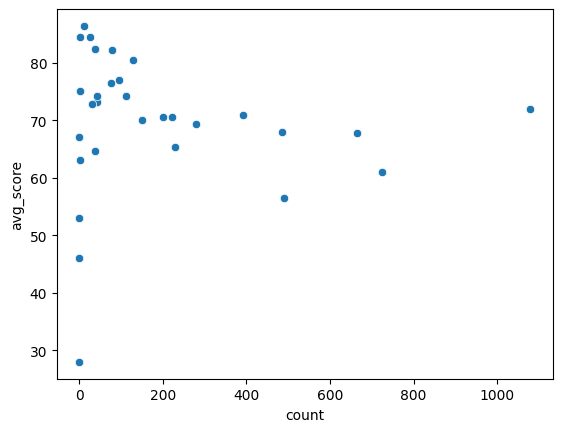

In [10]:
df_genres = df_cleaned.explode('genres')
genre_stats = df_genres.groupby('genres').agg(
    avg_score=('audience_score', 'mean'),
    count=('audience_score', 'size')
)
sns.scatterplot(
    x='count',
    y='avg_score',
    data=genre_stats
)

# Sentiment Analysis

## Data Prep

In [11]:
# Example of a review text
print(df_cleaned['critic_reviews'][1][0]['review_text'])

War of the Worlds attempts to boldly adapt H.G. Wells’ sci-fi classic for the modern age, the way that your digestive system boldly adapts a five-course dinner into excrement.


In [12]:
# Separate each review of movie
df_reviews = df_cleaned.explode('critic_reviews').reset_index(drop=True)
# Snapshot of what the data looks like now
print(df_reviews.head(2))

               title  year                                 emsId  \
0  War of the Worlds  2025  2828f421-1ed7-430d-94c3-e19235ba0d43   
1  War of the Worlds  2025  2828f421-1ed7-430d-94c3-e19235ba0d43   

                   vanity   type  critics_score  audience_score  \
0  war_of_the_worlds_2025  movie            4.0            20.0   
1  war_of_the_worlds_2025  movie            4.0            20.0   

                                           genres directors  \
0  [Sci-Fi, Adventure, Drama, Mystery & Thriller]        []   
1  [Sci-Fi, Adventure, Drama, Mystery & Thriller]        []   

                                                cast  \
0  [{'role': 'Actor', 'emsId': 'c745b7d3-1c29-394...   
1  [{'role': 'Actor', 'emsId': 'c745b7d3-1c29-394...   

                                      full_consensus         full_title  \
0  Critics Consensus\n        \nStranding Ice Cub...  War of the Worlds   
1  Critics Consensus\n        \nStranding Ice Cub...  War of the Worlds   

        

In [13]:
# Flatten the data
reviews_expanded = pd.json_normalize(df_reviews['critic_reviews'])
print(reviews_expanded.head(7))

              critic_name                                        review_text
0   Clement Tyler Obropta  War of the Worlds attempts to boldly adapt H.G...
1            Justin Brown  This was painful. It was boring, had terrible ...
2         Brandon Collins  There's so many tonal inconsistencies, Ice Cub...
3        Tatiana Albandos  I wish I didn't know this movie existed...I tr...
4  Leandro Ariel Porcelli  An absolutely inept family thriller. Balances ...
5            Brian Eggert  Undemanding in the worst ways, the movie’s dir...
6        Danielle Solzman  This Means War depends on audiences buying int...


In [14]:
df_reviews = (
    df_reviews
    .drop(columns=['critic_reviews'])
    .join(reviews_expanded)
)

In [15]:
df_reviews = df_reviews[df_reviews['review_text'].notna()]

## Analysis

In [16]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ayushinegi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
df_reviews['sentiment'] = df_reviews['review_text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

In [18]:
movie_sentiment = (
    df_reviews
    .groupby('emsId')['sentiment']
    .mean()
    .reset_index(name='avg_critic_sentiment')
)

In [33]:
df_cleaned = df_cleaned.merge(movie_sentiment, on='emsId', how='left')

print(df_cleaned.head(2))

               title  year                                 emsId  \
0  War of the Worlds  2025  2828f421-1ed7-430d-94c3-e19235ba0d43   
1     This Means War  2012  de81052c-61c1-36ba-9366-5c396e4a2b67   

                   vanity   type  critics_score  audience_score  \
0  war_of_the_worlds_2025  movie            4.0            20.0   
1          this_means_war  movie           24.0            56.0   

                                           genres directors  \
0  [Sci-Fi, Adventure, Drama, Mystery & Thriller]        []   
1                                [Action, Comedy]        []   

                                                cast  \
0  [{'role': 'Actor', 'emsId': 'c745b7d3-1c29-394...   
1  [{'role': 'Actor', 'emsId': 'e9ed7eb8-7773-3b6...   

                                      full_consensus         full_title  \
0  Critics Consensus\n        \nStranding Ice Cub...  War of the Worlds   
1  Critics Consensus\n        \nA career lowlight...     This Means War   

        

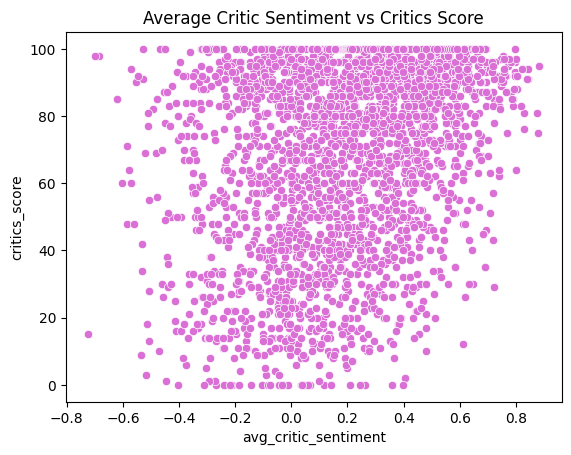

In [21]:
sns.scatterplot(
    x='avg_critic_sentiment',
    y='critics_score',
    data=df_cleaned,
    color='orchid'
)
plt.title('Average Critic Sentiment vs Critics Score')
plt.show()

In [22]:
df_cleaned[['avg_critic_sentiment', 'critics_score']].corr()

,avg_critic_sentiment,critics_score
avg_critic_sentiment,1.000000,0.268133
critics_score,0.268133,1.000000


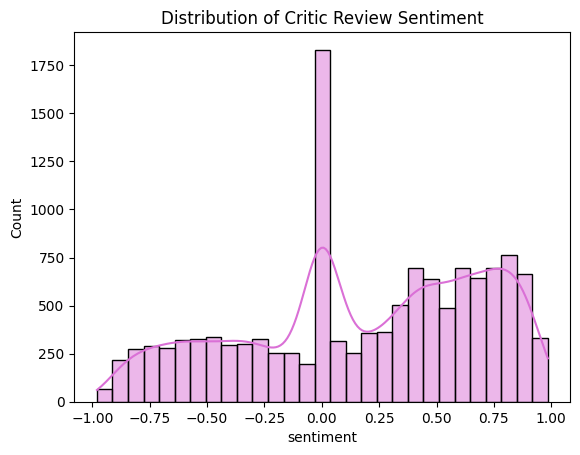

In [23]:
sns.histplot(df_reviews['sentiment'], kde=True, color='orchid')
plt.title('Distribution of Critic Review Sentiment')
plt.show()

In [24]:
df_genres = df_reviews.explode('genres')

df_genres.groupby('genres')['sentiment'].mean().sort_values()

genres
Travel               -0.415480
War                   0.012603
Horror                0.053172
Special Interest      0.088900
Crime                 0.092691
Mystery & Thriller    0.095383
Western               0.097543
History               0.174025
Drama                 0.177335
Action                0.183747
Documentary           0.199880
Sci-Fi                0.217753
Biography             0.237384
Adventure             0.269133
Fantasy               0.271914
Holiday               0.281089
LGBTQ+                0.282914
Comedy                0.300486
Animation             0.321907
Romance               0.330604
Anime                 0.332105
Kids & Family         0.333756
Music                 0.337866
Sports & Fitness      0.339920
Sports                0.370665
Musical               0.377309
Nature                0.387200
Short                 0.462450
Stand-Up              0.522180
Soap                  0.582040
Name: sentiment, dtype: float64

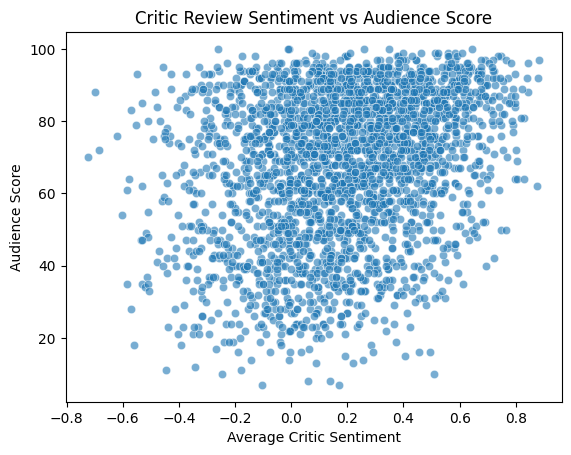

In [25]:
sns.scatterplot(
    x='avg_critic_sentiment',
    y='audience_score',
    data=df_cleaned,
    alpha=0.6
)

plt.title('Critic Review Sentiment vs Audience Score')
plt.xlabel('Average Critic Sentiment')
plt.ylabel('Audience Score')
plt.show()

In [26]:
df_cleaned[['avg_critic_sentiment', 'audience_score']].corr()

,avg_critic_sentiment,audience_score
avg_critic_sentiment,1.000000,0.270352
audience_score,0.270352,1.000000


In [27]:
df_cleaned['sentiment_label'] = pd.cut(
    df_cleaned['avg_critic_sentiment'],
    bins=[-1, -0.05, 0.05, 1],
    labels=['Negative', 'Neutral', 'Positive']
)

df_cleaned.groupby('sentiment_label')['audience_score'].mean()

/var/folders/0y/znbwkh157zlfxw9jdct4z_hm0000gn/T/ipykernel_56413/1031898501.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned.groupby('sentiment_label')['audience_score'].mean()


sentiment_label
Negative    60.459662
Neutral     62.721854
Positive    70.537500
Name: audience_score, dtype: float64

/var/folders/0y/znbwkh157zlfxw9jdct4z_hm0000gn/T/ipykernel_56413/2802476506.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


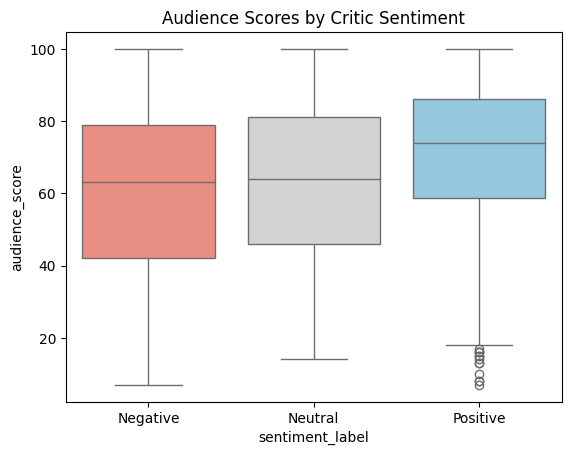

In [28]:
sns.boxplot(
    x='sentiment_label',
    y='audience_score',
    data=df_cleaned,
    palette=['salmon', 'lightgray', 'skyblue']
)

plt.title('Audience Scores by Critic Sentiment')
plt.show()

In [29]:
# Audience likes, critics dislike
disagree_movies = df_cleaned[
    (df_cleaned['avg_critic_sentiment'] < -0.2) &
    (df_cleaned['audience_score'] > 80)
][['title', 'genres', 'avg_critic_sentiment', 'audience_score']]

disagree_genres = disagree_movies.explode('genres')

genre_disagreement_counts = (
    disagree_genres['genres']
    .value_counts()
    .reset_index()
)

genre_disagreement_counts.columns = ['genre', 'disagreement_count']

# Total movies per genre
total_genre_counts = (
    df.explode('genres')['genres']
    .value_counts()
    .reset_index()
)

total_genre_counts.columns = ['genre', 'total_movies']

# Merge
genre_stats = genre_disagreement_counts.merge(
    total_genre_counts,
    on='genre'
)

# Disagreement rate
genre_stats['disagreement_rate'] = (
    genre_stats['disagreement_count'] /
    genre_stats['total_movies']
)

genre_stats = genre_stats.sort_values(
    'disagreement_rate',
    ascending=False
)

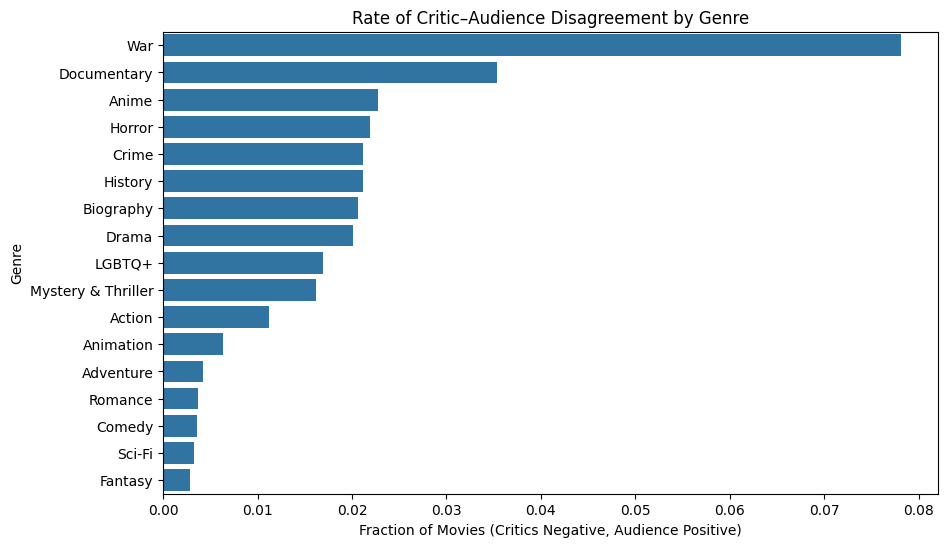

In [30]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='disagreement_rate',
    y='genre',
    data=genre_stats
)

plt.title('Rate of Critic–Audience Disagreement by Genre')
plt.xlabel('Fraction of Movies (Critics Negative, Audience Positive)')
plt.ylabel('Genre')
plt.show()

<Axes: xlabel='disagreement_count', ylabel='genre'>

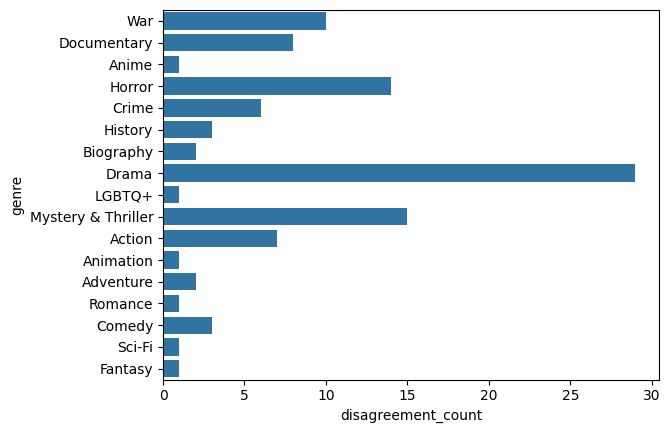

In [31]:
sns.barplot(
    x='disagreement_count',
    y='genre',
    data=genre_stats
)